<a href="https://colab.research.google.com/github/katrina906/CS6120-Summarization-Project/blob/main/compare_extractive_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# only using False versions of metrics because always choose the same models for both and thus all results are the same
  # TODO verify true for baseline (or at least metrics very similar)

In [1]:
%%capture 
!pip install rouge-score
!pip install import-ipynb

In [2]:
import pickle
from rouge_score import rouge_scorer
import import_ipynb
from nltk.corpus import stopwords  
import nltk
import matplotlib.pyplot as plt
import numpy as np
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load in functions from extract_summarization notebook
%cd "drive/MyDrive/Colab Notebooks"
import extractive_summarization
%cd ..

/content/drive/MyDrive/Colab Notebooks
importing Jupyter notebook from extractive_summarization.ipynb
/content/drive/MyDrive


### Load best models (one per algorithm, per metric)

In [274]:
model_dict = {}
eval_dict = {}
config_dict = {}
for model in ['lsa', 'textrank']: # 'baseline']: #'textrank']:
  with open('/content/drive/MyDrive/data/trained_model_' + model + '.pkl', 'rb') as f:
    load = pickle.load(f)
    eval_dict[model] = load[1]
    model_dict[model] = load[2]
    config_dict[model] = load[3]

## Calculate P-Value with Paired Bootstrap Test

For best configuration for each evaluation metric, compare the 3 model types: which model is the best and what is the p-value?
1. Calculate difference in stat performance (recall etc.)
2. Generate N bootstrapped samples of data 
3. Train on bootstrapped data
4. Calculate difference in performance on bootstraped data
5. Count percent of replicate diffs that are >= 2 * original diff = p-value  
  - Null hypothesis is that there is no difference and the true effect size is original diff (data happens to be biased towards one model)
  - If see a lot of replicated diffs >= 2 * original diff, then null is true and there is no difference between the models

In [ ]:
def paired_bootstrap(evals, models, configs, model1, model2):
  embeddings = extractive_summarization.load_embeddings()

  pvalue_dict = {}
  for metric in [('fmeasure', False), ('precision', False), ('recall', False)]:

    # which model is better and by how much
    if evals[model1][metric]['mean'] > evals[model2][metric]['mean']:
      better_model = model1
      other_model = model2
    else:
      better_model = model2
      other_model = model1
    diff =  evals[better_model][metric]['mean'] - evals[other_model][metric]['mean']
    print(better_model, diff)

    #bs_results_sd = []
    gt_diff = 0
    lt_diff = 0
    for i in range(50): # TODO need more samples...once have more full models, see how big standard deviation of means are with BS = 10, 20 etc. Need to go bigger? 
                        # definitely more than 10 so can get fractions beyond 0 and 0.1
      print('BS', i)
      # generate bootstrap samples 
      bs_sample = {}
      bs_sample[model1] = models[model1][metric].sample(n = len(models[model1][metric]), replace = True)
      bs_sample[model2] = models[model2][metric].sample(n = len(models[model2][metric]), replace = True)

      # retrain both models on bootstrap samples with the current config
      bs_results = {}
      for m in [model1, model2]:
        config = tuple(config_dict[m][metric].strip('(').strip(')').replace("'", "").split(', '))
        if 'baseline' in config:
          tfidf, feature_array = extractive_summarization.corpus_tfidf(bs_sample[m])
        else:
          tfidf = ''
          feature_array = ''
        eval_results, _ = extractive_summarization.train_config_loop(bs_sample[m], tfidf, feature_array, embeddings, stop_words, 
                                                                     [config], eval_only = True)
        bs_results[m] = eval_results[str(config)][metric]['mean']
    
      #bs_results_sd.append(eval_results[config][metric]['mean'])
    #return bs_results_sd
      # find difference in relevant stat
      diff_bs = bs_results[better_model] - bs_results[other_model]
      print(diff_bs)
      if diff_bs >= 2*diff:
        gt_diff += 1
      else:
        lt_diff += 1
      
    # calculate p value
    pvalue = gt_diff / (gt_diff + lt_diff)
    pvalue_dict[metric] = (better_model, pvalue)

  return pvalue_dict

In [ ]:
pvalue_dict = paired_bootstrap(eval_dict, model_dict, config_dict, 'lsa', 'lsa')

In [276]:
config_dict
# lsa always no normalization, stemming, bow, all 3 grams
# textrank always stem, bow, cosine similarity 
# never embeddings used

{'lsa': {('fmeasure',
   False): "('lsa', 'nostop', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_sentences')",
  ('fmeasure',
   True): "('lsa', 'nostop', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_sentences')",
  ('precision',
   False): "('lsa', 'stopwords', 'stem', 'bow', 'counts', 'no_normalization', 'trigram', 'num_words_lt')",
  ('precision',
   True): "('lsa', 'stopwords', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_words_lt')",
  ('recall',
   False): "('lsa', 'nostop', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_sentences')",
  ('recall',
   True): "('lsa', 'nostop', 'stem', 'bow', 'binary', 'no_normalization', 'all', 'num_sentences')"},
 'textrank': {('fmeasure',
   False): "('textrank', 'stopwords', 'stem', 'bow', 'binary', 'no_normalization', 'bigram', 'cosine', 'num_words_gt')",
  ('fmeasure',
   True): "('textrank', 'stopwords', 'stem', 'bow', 'binary', 'no_normalization', 'bigram', 'cosine', 'num_words_gt')",
  ('precis

### Compare algorithm performance

Text(0.5, 1.0, 'TextRank Uniformally Outperforms other Models')

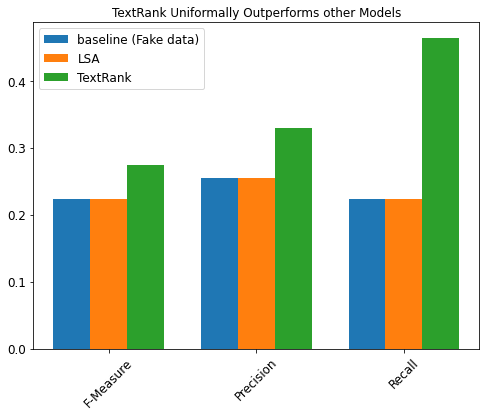

In [275]:
# side by side metric values for each metric across models (bar plot)
fig, ax = plt.subplots(figsize=(8,6))
mean_lst = {'lsa':[], 'textrank':[], 'baseline':[]}
for metric in [('fmeasure', False), ('precision', False), ('recall', False)]:
  for model in ['lsa', 'textrank']:
    mean_lst[model].append(eval_dict[model][metric]['mean'])
x = np.arange(len(metric_lst))
w = 0.25
ax.bar(x, mean_lst['lsa'], width = w, label = 'baseline (Fake data)')
ax.bar(x + w, mean_lst['lsa'], width = w, label = 'LSA')
ax.bar(x + 2*w, mean_lst['textrank'], width = w, label = 'TextRank')
ax.legend(fontsize = 12)
ax.set_xticks(x + w)
ax.set_xticklabels(['F-Measure', 'Precision', 'Recall'], rotation = 45)
ax.tick_params(axis='both', which='major', labelsize = 12)
ax.set_title('TextRank Uniformally Outperforms other Models', size = 12)

# TODO mark if significant? annotate?

# note fmeasure and precision models the same for LSA

## Compare Predicted Summaries across Algorithms and Metrics


In [277]:
# length of summary by metric within model
summary_len_metric = {'lsa':{}, 'textrank':{}}
for model in ['lsa', 'textrank']:
  for metric in [('fmeasure', False), ('precision', False), ('recall', False)]:
    df = model_dict[model][metric]
    df['summary_num_words'] = df.predicted_summary.map(lambda row: len(''.join(row).split(' ')))
    df['summary_num_sentences'] = df.predicted_summary.map(lambda row: len(row))
    summary_len_metric[model][metric] = [df.summary_num_sentences.mean(), df.summary_num_words.mean()]

Text(0.5, 1.0, 'TextRank')

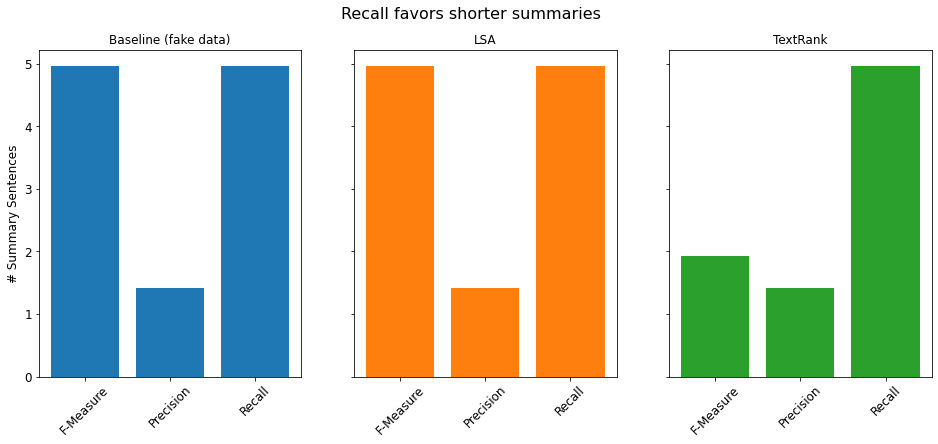

In [285]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
barlst = axs[0].bar(['F-Measure', 'Precision', 'Recall'], [i[0] for i in list(summary_len_metric['lsa'].values())], color = 'C0')
barlst = axs[1].bar(['F-Measure', 'Precision', 'Recall'], [i[0] for i in list(summary_len_metric['lsa'].values())], color = 'C1')
barlst = axs[2].bar(['F-Measure', 'Precision', 'Recall'], [i[0] for i in list(summary_len_metric['textrank'].values())], color = 'C2')

for i in range(3):
  axs[i].set_xticklabels(['F-Measure', 'Precision', 'Recall'], rotation = 45)
  axs[i].tick_params(axis='both', which='major', labelsize = 12)
fig.suptitle('Precision favors shorter summaries', size = 16)
axs[0].set_ylabel('# Summary Sentences', size = 12)
axs[0].set_title('Baseline (fake data)')
axs[1].set_title("LSA")
axs[2].set_title('TextRank')

# all 3 models get very similar sized summaries
# precision favors shorter summaries. maximizing overlap with predicted summary, so extra non relevant info hurts 

In [ ]:
# TODO stats on types of summaries generated by each model and for best of each metric. Ex: recall best summaries longer than precision summaries? etc.
# problems with models include that sentences can appear in odd orders. BUT our human content creator can rearrange - care more about getting the right info in front of them.
  # thus prefer longer summaries? care more about recall than precision?